This Jupyter notebook presents an analysis of an e-commerce dataset, "TMall." The goal of this analysis is to address the primary research question:

How can user behavior on the platform be optimized to increase the likelihood of purchases?

Methodology To address this question, the analysis will begin with an exploratory phase, examining the contents of the provided parquet file, TMall. This step will clarify the dataset’s structure and reveal variables that can inform further analysis, enabling a thorough understanding of the raw data.

Following the exploration, we will select key features aligned with the research question, constructing a streamlined data frame focused on these relevant features.

The analysis will proceed in two main stages:

Descriptive Analysis – Summarizing and interpreting the main characteristics of the data using descriptive statistics to gain an overview of trends and patterns.

Inferential Analysis – Applying inferential statistics to explore relationships within the data and draw insights relevant to the research question.

After these initial descriptive analyses, additional features will be engineered to enhance relevance to the main research question.

Insights from this exploratory phase will guide the formation of specific sub-questions to support a structured approach for addressing the primary research question.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Did not use all these libraries but I did experiment a lot.

In [9]:
# Load data set
directory = '/content/TMall.parquet'
df = pd.read_parquet (directory)

# Display options to show all columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.width', None)        # Adjust display

# Display the DataFrame
print(df.head(5))
print(df.info())

# Print the total number of rows in the dataset
print("Total number of rows:", df.shape[0])

                                 SSID user_session  session  visitorid               timestamp  \
1092725   201308271734260100000055339    1000000_0        0    1000000 2013-08-27 17:34:00.626   
1942407  2013052416242601000001320115    1000001_0        0    1000001 2013-05-24 16:24:31.738   
1073483  2013082622502601000002376356    1000002_0        0    1000002 2013-08-26 22:50:57.216   
837287   2013081308262601000003422529    1000003_0        0    1000003 2013-08-13 08:26:28.112   
324990   2013061702082601000007300114    1000007_0        0    1000007 2013-06-17 02:08:42.130   

         itemid  event  event_duration  events_per_session    PageTime  PathLength  \
1092725   55339      2      260.718177                   1  260.718177           1   
1942407  320115      2      260.718177                   1  260.718177           1   
1073483  376356      2      260.718177                   1  260.718177           1   
837287   422529      2      260.718177                   1  260.718

In [10]:
# Step 1: Data Cleaning

# 1. Inspect the dataset
print("Initial Data Overview:\n")
print("Column Names:", df.columns)
print("First Few Rows:\n", df.head())
print("\nData Types and Null Values:\n")
print(df.info())
print("\nSummary Statistics:\n")
print(df.describe())

# 2. Checking for missing values in each column
print("\nMissing values in each column:\n")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# 3. Handle Missing Values
# - Fill time-based metrics with 0 if missing, Here I'm assuming missing values indicate no activity.
time_columns = [
    'TotalViewingTime', 'TotalATCTime', 'TotalPurchaseTime',
    'time_since_last_view', 'time_since_last_ATC',
    'time_since_last_purchase', 'time_since_last_event'
]
df[time_columns] = df[time_columns].fillna(0)

# - Fill frequency and count metrics with 0 if missing
count_columns = [
    'AmountOfItemsViewed', 'AmountOfItemsPurchased', 'AmountOfItemsATC',
    'Frequency_A0', 'Frequency_A1', 'Frequency_A2', 'events_per_session'
]
df[count_columns] = df[count_columns].fillna(0)

# - Handle categorical columns by filling missing values with the most frequent value (mode)
#Fill missing categorical values with mode, it helps to preserve category distribution and avoid data loss

categorical_columns = ['TimeOfDay', 'WeekdayVsWeekend', 'Month', 'Season']
for column in categorical_columns:
    df[column] = df[column].fillna(df[column].mode()[0])




Initial Data Overview:

Column Names: Index(['SSID', 'user_session', 'session', 'visitorid', 'timestamp', 'itemid', 'event',
       'event_duration', 'events_per_session', 'PageTime', 'PathLength', 'TotalViewingTime',
       'TotalATCTime', 'TotalPurchaseTime', 'AmountOfItemsViewed', 'AmountOfItemsPurchased',
       'AmountOfItemsATC', 'Frequency_A0', 'Frequency_A1', 'Frequency_A2', 'AvgTimeOfViewing',
       'AvgTimeOfATC', 'AvgTimeOfPurchasing', 'time_since_last_view', 'time_since_last_ATC',
       'time_since_last_purchase', 'time_since_last_event', 'TimeOfDay', 'WeekdayVsWeekend',
       'Month', 'Season', 'ATC', 'Purchase'],
      dtype='object')
First Few Rows:
                                  SSID user_session  session  visitorid               timestamp  \
1092725   201308271734260100000055339    1000000_0        0    1000000 2013-08-27 17:34:00.626   
1942407  2013052416242601000001320115    1000001_0        0    1000001 2013-05-24 16:24:31.738   
1073483  20130826225026010000

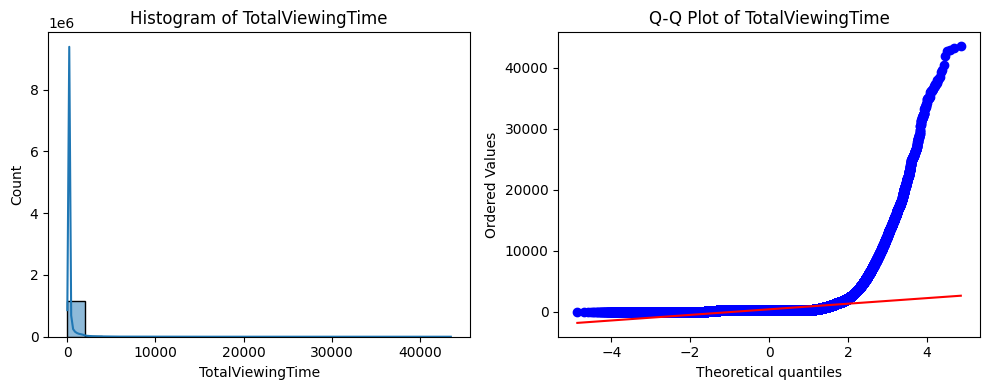

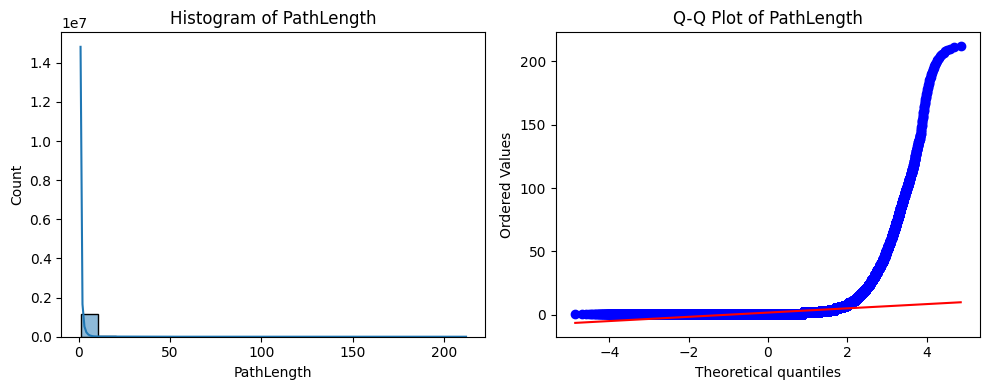

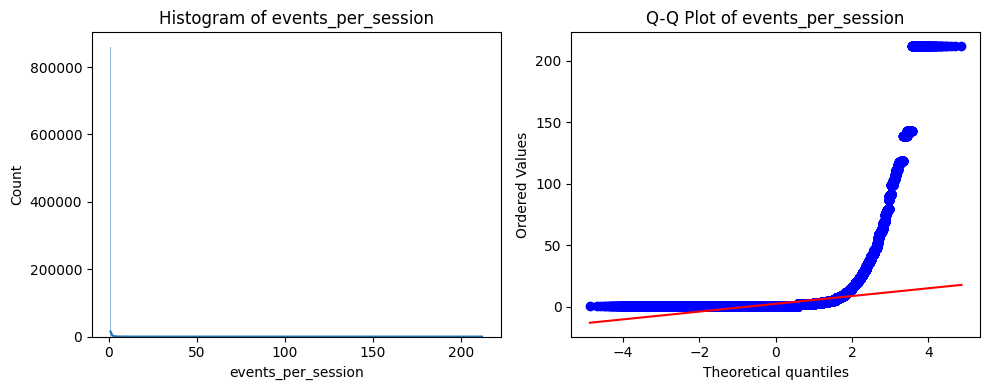

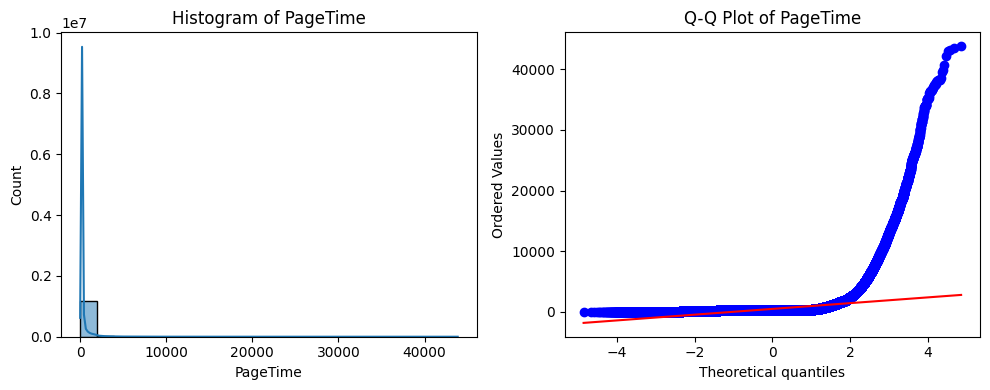

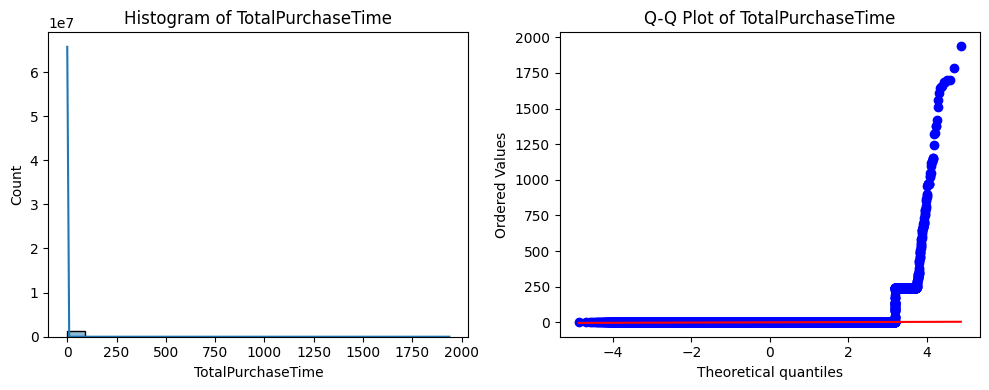

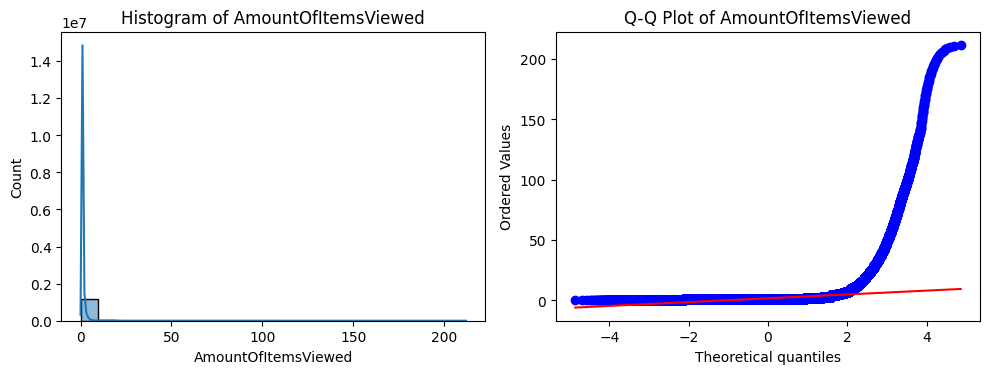

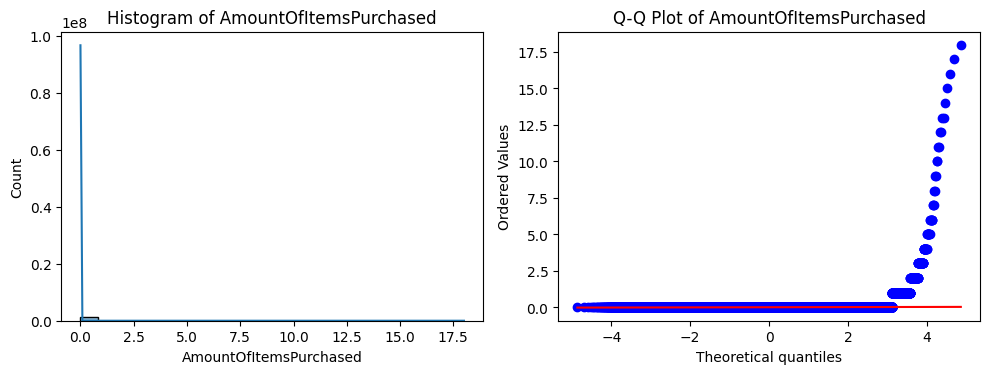

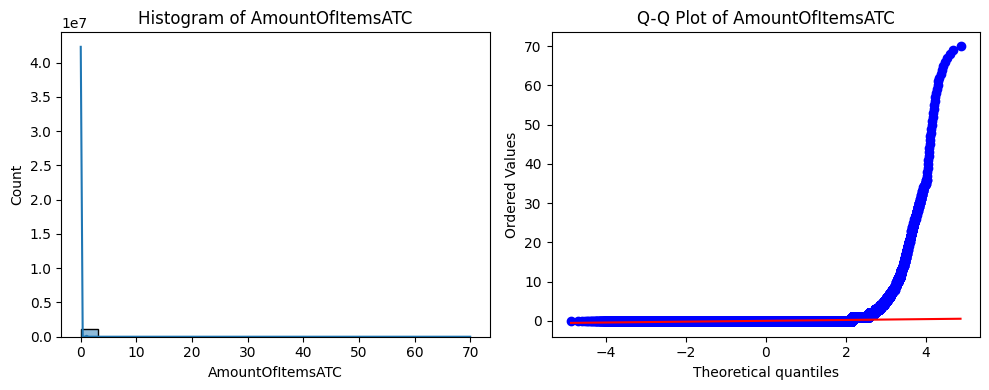

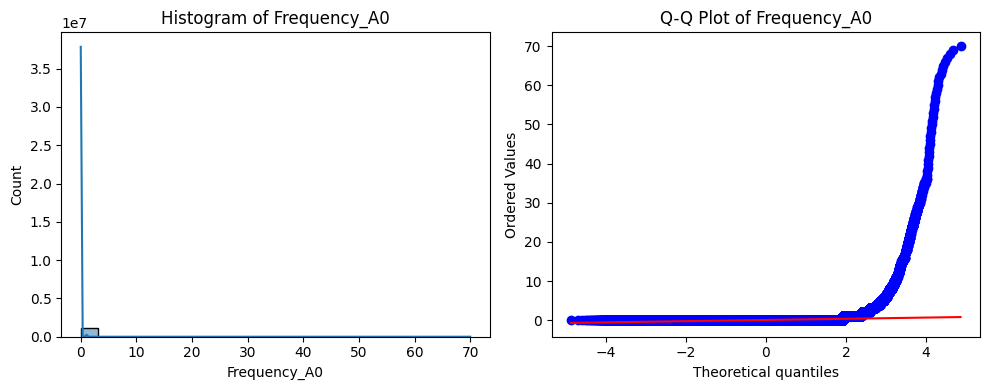

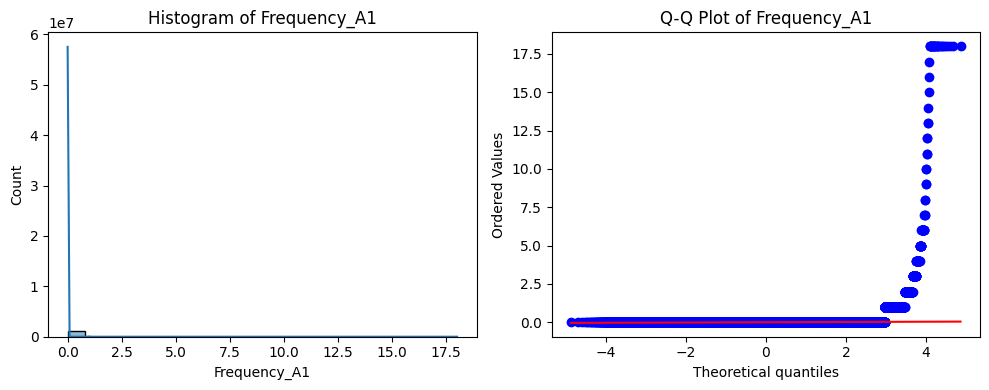

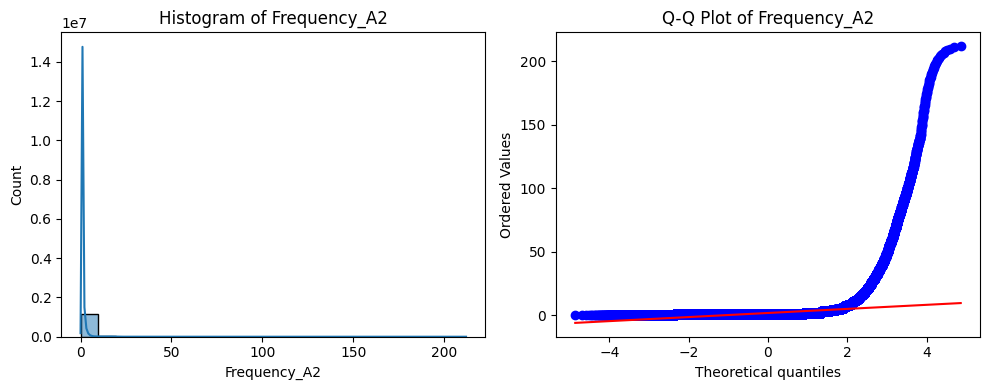

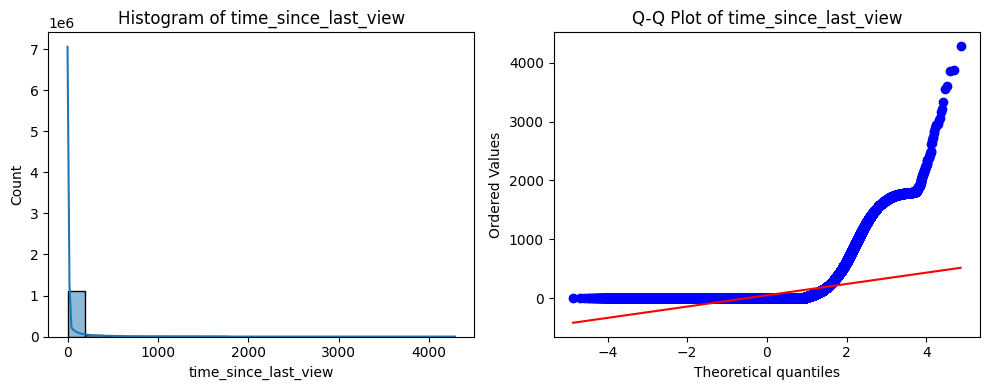

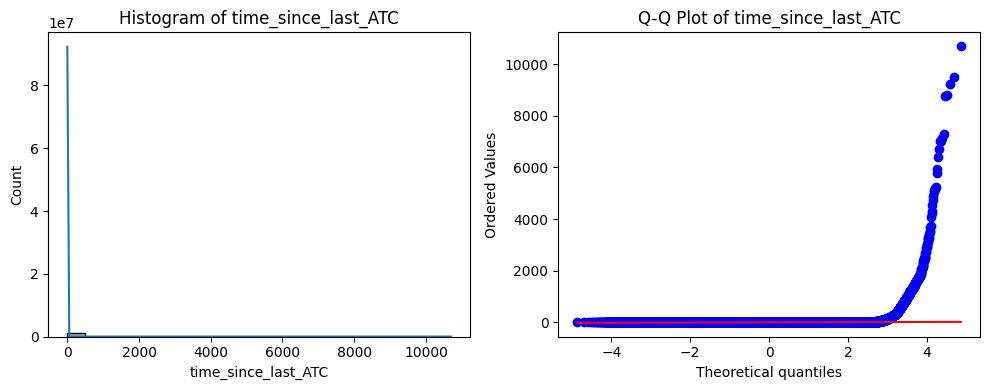

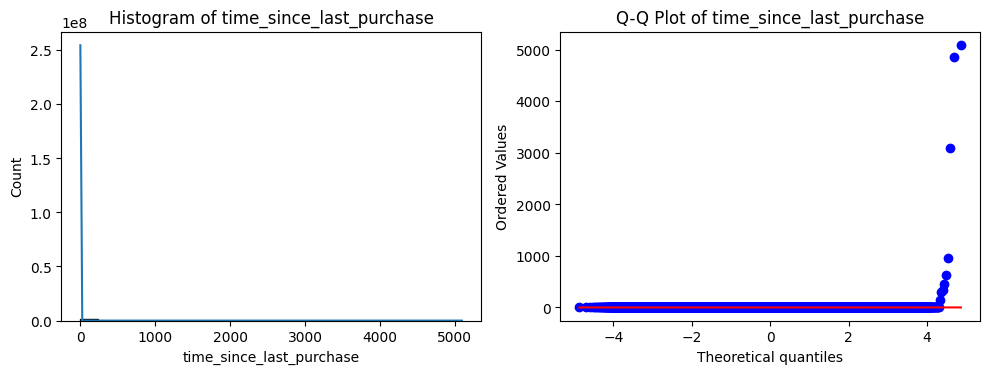

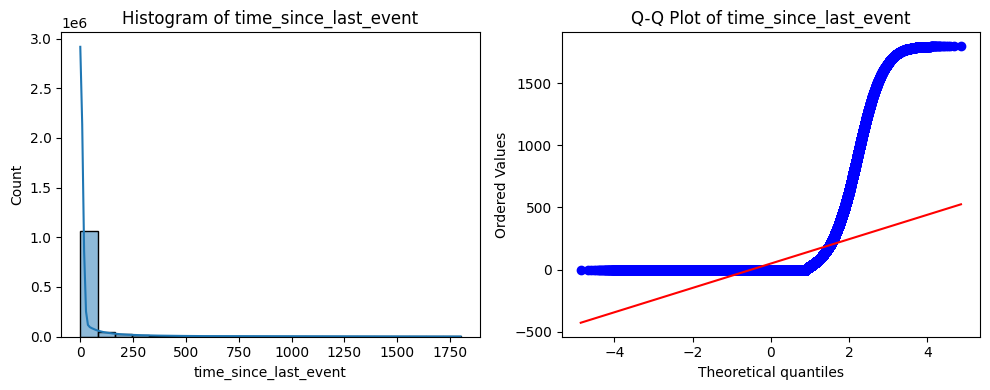

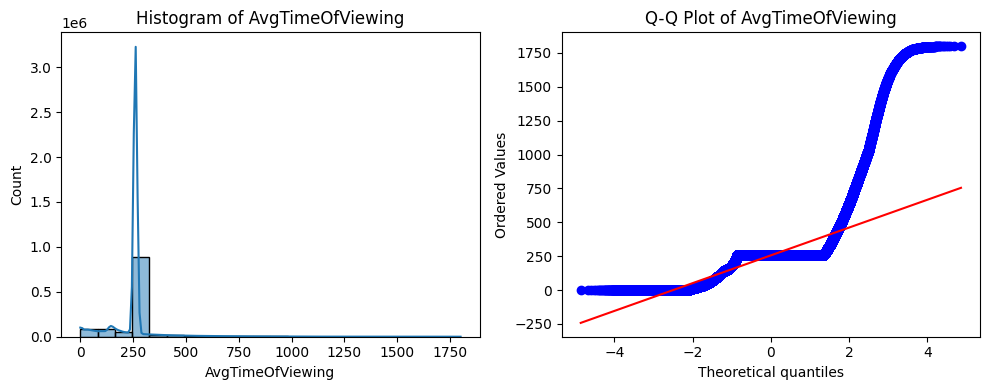

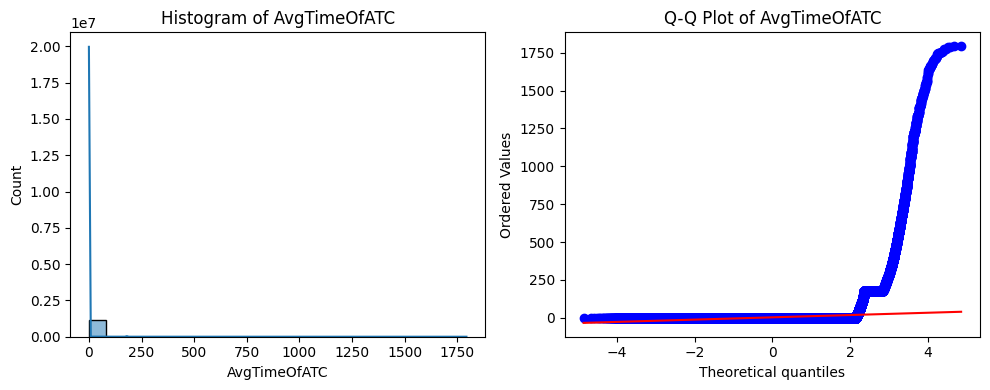

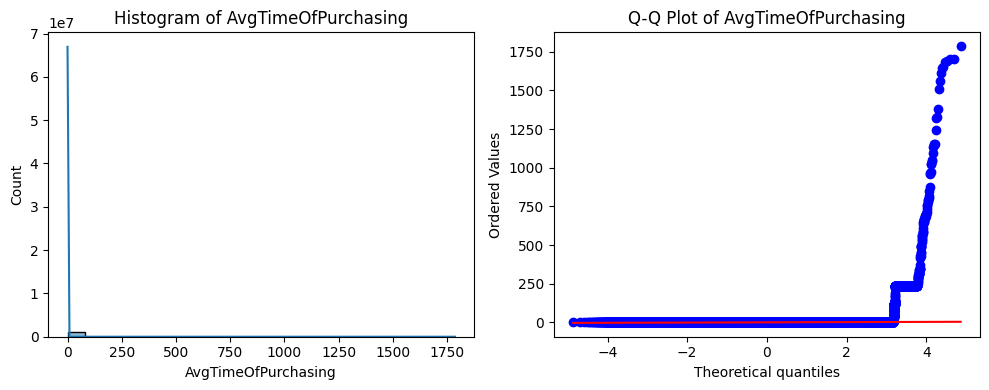

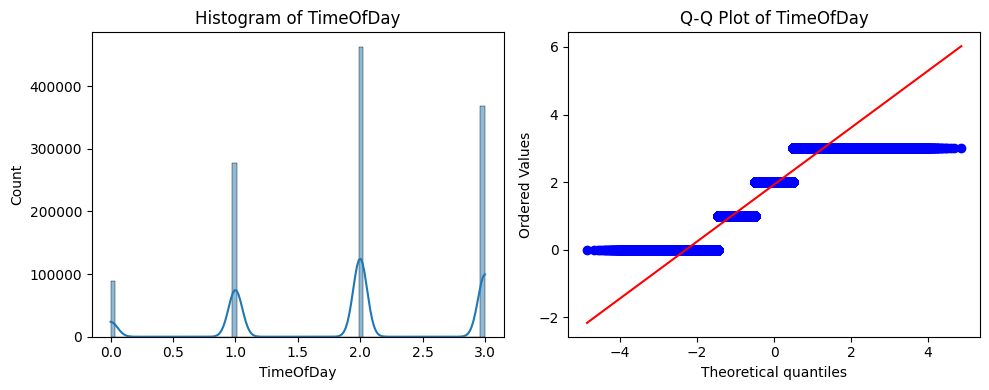

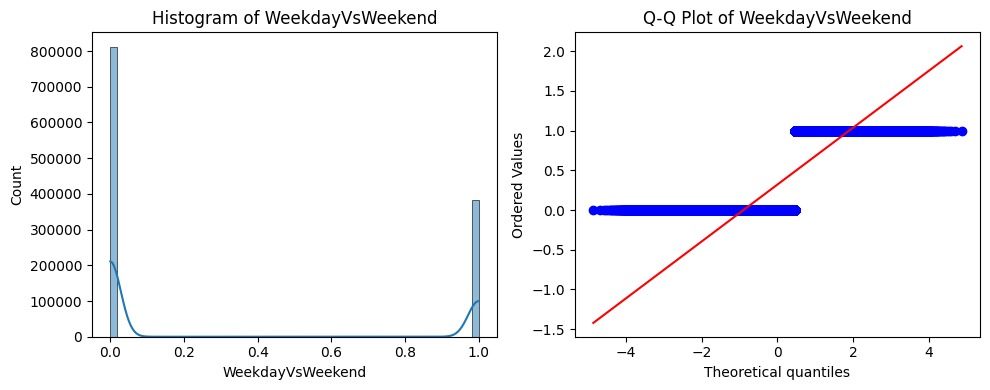

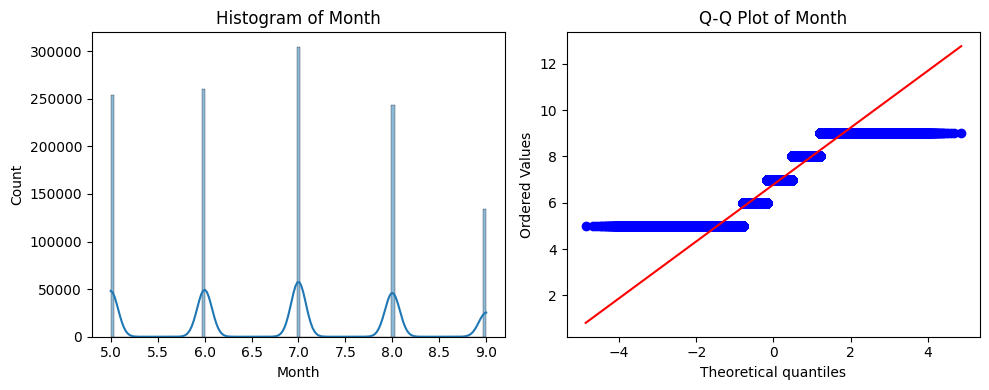

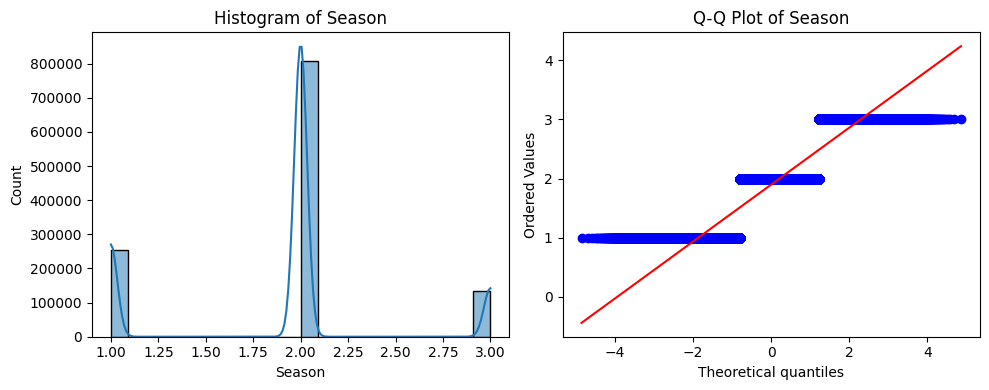

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1196087.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk test for TotalViewingTime: p-value=0.00000
   -> TotalViewingTime is likely not normally distributed (reject H0)
Shapiro-Wilk test for PathLength: p-value=0.00000
   -> PathLength is likely not normally distributed (reject H0)
Shapiro-Wilk test for events_per_session: p-value=0.00000
   -> events_per_session is likely not normally distributed (reject H0)
Shapiro-Wilk test for PageTime: p-value=0.00000
   -> PageTime is likely not normally distributed (reject H0)
Shapiro-Wilk test for TotalPurchaseTime: p-value=0.00000
   -> TotalPurchaseTime is likely not normally distributed (reject H0)
Shapiro-Wilk test for AmountOfItemsViewed: p-value=0.00000
   -> AmountOfItemsViewed is likely not normally distributed (reject H0)
Shapiro-Wilk test for AmountOfItemsPurchased: p-value=0.00000
   -> AmountOfItemsPurchased is likely not normally distributed (reject H0)
Shapiro-Wilk test for AmountOfItemsATC: p-value=0.00000
   -> AmountOfItemsATC is likely not normally distributed (reject 

In [13]:
#Checking features of interst for normality incase I want to use any mean based analaysis later on.
# List of selected features
selected_features = [
    'TotalViewingTime', 'PathLength', 'events_per_session', 'PageTime',
    'TotalPurchaseTime', 'AmountOfItemsViewed', 'AmountOfItemsPurchased',
    'AmountOfItemsATC', 'Frequency_A0', 'Frequency_A1', 'Frequency_A2',
    'time_since_last_view', 'time_since_last_ATC', 'time_since_last_purchase',
    'time_since_last_event', 'AvgTimeOfViewing', 'AvgTimeOfATC', 'AvgTimeOfPurchasing',
    'TimeOfDay', 'WeekdayVsWeekend', 'Month', 'Season'
]

# Plot histograms and Q-Q plots
for feature in selected_features:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Histogram of {feature}')

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {feature}')

    plt.tight_layout()
    plt.show()

# Shapiro Wilk test for normality
for feature in selected_features:
    stat, p_value = stats.shapiro(df[feature].dropna())  # Drop NaNs for Shapiro test
    print(f'Shapiro-Wilk test for {feature}: p-value={p_value:.5f}')
    if p_value < 0.05:
        print(f"   -> {feature} is likely not normally distributed (reject H0)")
    else:
        print(f"   -> {feature} is likely normally distributed (fail to reject H0)")


From the Shapiro-Wilk test results, it appears that none of the selected features are normally distributed (all p-values are 0.00000, leading to rejection of the null hypothesis of normality). This means that moving forward I will have to use standardscaler to normalize the data X_train and X_test for training and evaluating the logistic regression model as well as logistic regression’s cross-validation across all folds.

I want to see if there are any trends in the data that is why we will use both the random forest and logestic regression models as they will allow me to combine the predictive power and felxibilty of random forest with the interpretabilty and clarity of logestic regression.

Random forest helps to find patterns in the data that may be complex and not easily seen, improving the accuracy of predictions. It shows which features (like TotalPurchaseTime or AmountOfItemsPurchased) have a strong influence on the outcome, even if the relationships are complicated.

Logistic regression offers a more straightforward view by showing if each feature has a positive or negative effect on the outcome. It is eaier to understand becuase each feature's effect is clear.

Sources:

1) https://builtin.com/data-science/shapiro-wilk-test

2) https://www.geeksforgeeks.org/logistic-regression-vs-random-forest-classifier/


Random Forest Cross-Validation Accuracy: 0.9999991639390178
Random Forest Feature Importances:
                      Feature  Importance
4          TotalPurchaseTime    0.288494
17       AvgTimeOfPurchasing    0.256200
6     AmountOfItemsPurchased    0.178000
9               Frequency_A1    0.102599
7           AmountOfItemsATC    0.058515
13  time_since_last_purchase    0.027170
8               Frequency_A0    0.024826
16              AvgTimeOfATC    0.019806
5        AmountOfItemsViewed    0.011518
11      time_since_last_view    0.008645
15          AvgTimeOfViewing    0.006509
10              Frequency_A2    0.006311
0           TotalViewingTime    0.004733
3                   PageTime    0.004032
1                 PathLength    0.000907
2         events_per_session    0.000791
12       time_since_last_ATC    0.000505
14     time_since_last_event    0.000438
18                 TimeOfDay    0.000000
19          WeekdayVsWeekend    0.000000
20                     Month    0.000000
21

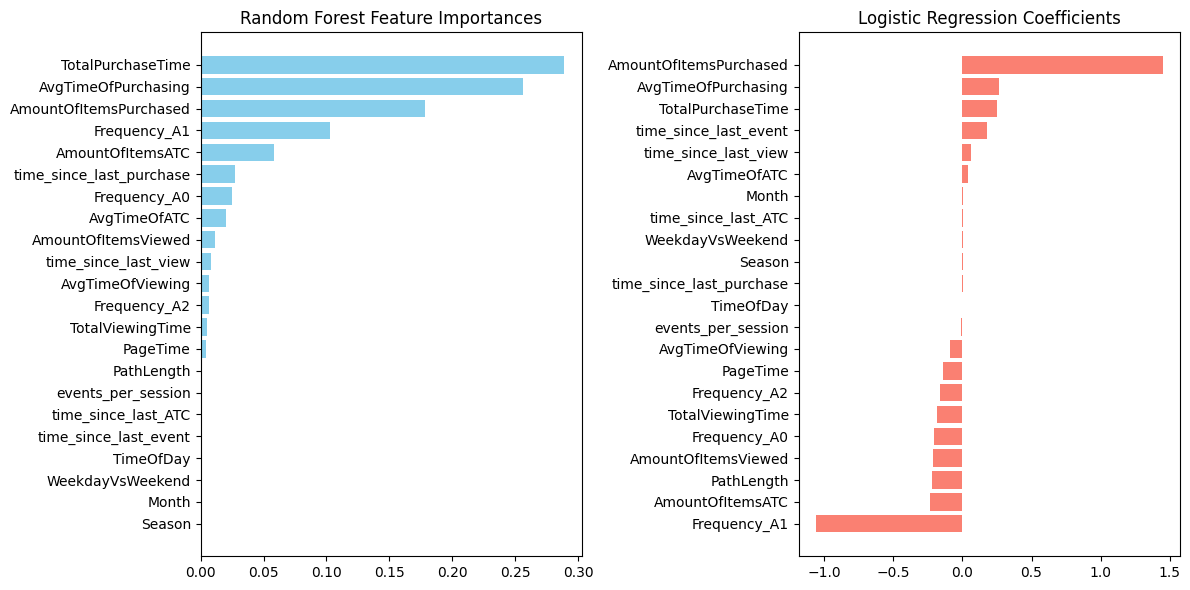

In [14]:
# Split the data into features and target
X = df[selected_features]
y = df['Purchase']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_importances = rf_model.feature_importances_

# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5)
print("Random Forest Cross-Validation Accuracy:", rf_cv_scores.mean())

# Feature importance from Random Forest
rf_feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importances:\n", rf_feature_importances)

# 2. Logistic Regression Model
# Scale the entire feature set for cross-validation
X_scaled = scaler.fit_transform(X)

logreg_model = LogisticRegression(random_state=42, max_iter=1000)
logreg_model.fit(X_train_scaled, y_train)
logreg_coefficients = logreg_model.coef_[0]

# Cross-validation for Logistic Regression
logreg_cv_scores = cross_val_score(logreg_model, X_scaled, y, cv=5)
print("Logistic Regression Cross-Validation Accuracy:", logreg_cv_scores.mean())

# Coefficients from Logistic Regression
logreg_feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': logreg_coefficients
}).sort_values(by='Coefficient', ascending=False)
print("Logistic Regression Coefficients:\n", logreg_feature_importances)

# Plot both feature importances for visual comparison
plt.figure(figsize=(12, 6))

# Random Forest Feature Importance Plot
plt.subplot(1, 2, 1)
plt.barh(rf_feature_importances['Feature'], rf_feature_importances['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importances')

# Logistic Regression Coefficients Plot
plt.subplot(1, 2, 2)
plt.barh(logreg_feature_importances['Feature'], logreg_feature_importances['Coefficient'], color='salmon')
plt.gca().invert_yaxis()
plt.title('Logistic Regression Coefficients')

plt.tight_layout()
plt.show()

Model Performance
Both models achieved exceptionally high cross-validation accuracy, indicating excellent predictive performance:

Random Forest Cross-Validation Accuracy: 99.9999%

Logistic Regression Cross-Validation Accuracy: 99.9978%

These high accuracy scores suggest that the models can very effectively distinguish between the classes in the dataset. However this might be evidence that the models are overfitting. This happens when the model captures noise or irrelevant patterns in the training data, leading to high accuracy but poor generalization to new data.

To test if models actually perform well and confirm that less important features don't significantly impact model accuracy I will run a PCA below.




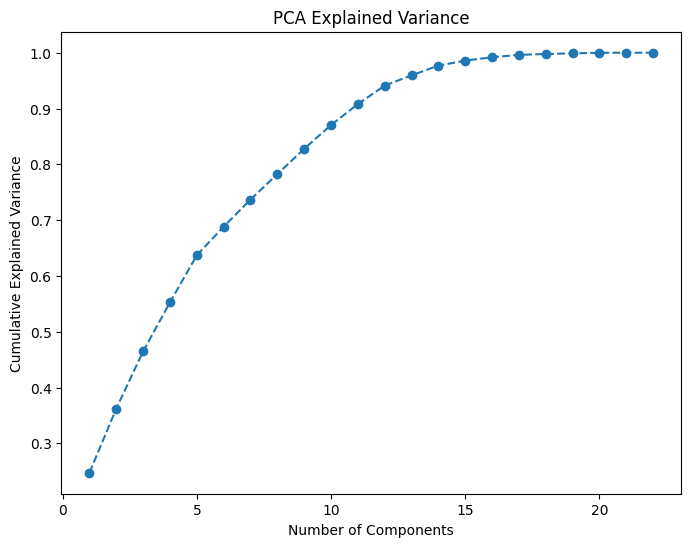

In [16]:
#Assuming `df` is your dataframe and `selected_features` is a list of feature names
# Define `X` and `y`
X = df[selected_features]
y = df['Purchase']

# Standardize the entire feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Using your original feature set `X`

# Initialize PCA with as many components as there are features
pca = PCA(n_components=len(selected_features))
X_pca = pca.fit_transform(X_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(selected_features) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

# Based on the cumulative variance plot, choose the optimal number of components, e.g., 10
pca = PCA(n_components=15)
X_reduced = pca.fit_transform(X_scaled)

The elbow point above is at about 15 as that is where the varience starts to level off. This now gives me 15 components.



In [17]:
# Redefine PCA with the optimal number of components.
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [18]:
# Random Forest with PCA-reduced data
rf_model_pca = RandomForestClassifier(random_state=42)
rf_model_pca.fit(X_train_pca, y_train)
rf_pca_cv_scores = cross_val_score(rf_model_pca, X_train_pca, y_train, cv=5)
print("Random Forest with PCA Cross-Validation Accuracy:", rf_pca_cv_scores.mean())

# Logistic Regression with PCA-reduced data
logreg_model_pca = LogisticRegression(random_state=42, max_iter=1000)
logreg_model_pca.fit(X_train_pca, y_train)
logreg_pca_cv_scores = cross_val_score(logreg_model_pca, X_train_pca, y_train, cv=5)
print("Logistic Regression with PCA Cross-Validation Accuracy:", logreg_pca_cv_scores.mean())

Random Forest with PCA Cross-Validation Accuracy: 0.9999979098519131
Logistic Regression with PCA Cross-Validation Accuracy: 1.0


Since for both models the cross validation scores are close to 1 it idicates excellent performance even with PCA. At this stage my sub research question is : What are the key factors associated with a higher likelihood of making a purchase?

Since PCA transforms the features into principal components, it reduces the clarity of the analysis by combining original features. To interpret specific features directly I will use logistic regression on the original data befire I conducted the PCA.

In [19]:
# Fit the logistic regression on the original scaled data
logreg_model = LogisticRegression(random_state=42, max_iter=1000)
logreg_model.fit(X_train_scaled, y_train)

# Extract and interpret the coefficients
logreg_coefficients = logreg_model.coef_[0]
logreg_feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': logreg_coefficients
}).sort_values(by='Coefficient', ascending=False)

print("Logistic Regression Coefficients:\n", logreg_feature_importances)


Logistic Regression Coefficients:
                      Feature  Coefficient
6     AmountOfItemsPurchased     1.448647
17       AvgTimeOfPurchasing     0.266541
4          TotalPurchaseTime     0.247556
14     time_since_last_event     0.176128
11      time_since_last_view     0.059513
16              AvgTimeOfATC     0.037444
20                     Month     0.007446
12       time_since_last_ATC     0.004607
19          WeekdayVsWeekend     0.002106
21                    Season     0.001692
13  time_since_last_purchase     0.001182
18                 TimeOfDay    -0.002801
2         events_per_session    -0.013449
15          AvgTimeOfViewing    -0.086049
3                   PageTime    -0.140813
10              Frequency_A2    -0.161163
0           TotalViewingTime    -0.183977
8               Frequency_A0    -0.202107
5        AmountOfItemsViewed    -0.212956
1                 PathLength    -0.217029
7           AmountOfItemsATC    -0.236743
9               Frequency_A1    -1.058229

In [20]:


logreg_feature_importances['Odds Ratio'] = np.exp(logreg_feature_importances['Coefficient'])
print("Logistic Regression Odds Ratios:\n", logreg_feature_importances)


Logistic Regression Odds Ratios:
                      Feature  Coefficient  Odds Ratio
6     AmountOfItemsPurchased     1.448647    4.257352
17       AvgTimeOfPurchasing     0.266541    1.305442
4          TotalPurchaseTime     0.247556    1.280891
14     time_since_last_event     0.176128    1.192591
11      time_since_last_view     0.059513    1.061319
16              AvgTimeOfATC     0.037444    1.038154
20                     Month     0.007446    1.007474
12       time_since_last_ATC     0.004607    1.004618
19          WeekdayVsWeekend     0.002106    1.002108
21                    Season     0.001692    1.001693
13  time_since_last_purchase     0.001182    1.001183
18                 TimeOfDay    -0.002801    0.997203
2         events_per_session    -0.013449    0.986641
15          AvgTimeOfViewing    -0.086049    0.917549
3                   PageTime    -0.140813    0.868652
10              Frequency_A2    -0.161163    0.851154
0           TotalViewingTime    -0.183977    0.8

Key Positive Factors (Top Predictors for Purchase Likelihood):
Based on the coefficients and odds ratios from the logistic regression output:

AmountOfItemsPurchased: This feature has the highest positive coefficient (1.448647) and an odds ratio of 4.257552, meaning that a higher amount of items purchased is strongly associated with a higher likelihood of making another purchase.

TotalPurchaseTime: With a positive coefficient (0.247556) and an odds ratio of 1.28085, this suggests that users who spend more total time in the purchasing process are more likely to make a purchase.

time_since_last_event and time_since_last_view: These positive coefficients (0.176128 and 0.059513) indicate that users who have interacted with the platform recently are more likely to make a purchase.

AvgTimeOfPurchasing: Positive with a coefficient of 0.266541 (odds ratio 1.305442), suggesting that users who tend to purchase during certain times of the day might be more likely to complete a purchase.


---


Key Negative Factors (Features That Lower Purchase Likelihood):

Frequency_A1: This feature has a strongly negative coefficient (-1.058229) with an odds ratio of 0.34707, meaning that high frequency in this category is associated with a lower likelihood of purchase.

AmountOfItemsViewed: With a small negative coefficient (-0.211926) and odds ratio (0.809151), this suggests that users who view more items may not necessarily purchase, perhaps indicating browsing behavior without buying intent.

Frequency_A0 and Frequency_A2: Both have negative coefficients, suggesting that specific interaction frequencies in these categories are associated with a lower likelihood of purchasing.


In [21]:
# Random Forest Feature Importance (from your existing code)
rf_feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importances:\n", rf_feature_importances)


Random Forest Feature Importances:
                      Feature  Importance
4          TotalPurchaseTime    0.288494
17       AvgTimeOfPurchasing    0.256200
6     AmountOfItemsPurchased    0.178000
9               Frequency_A1    0.102599
7           AmountOfItemsATC    0.058515
13  time_since_last_purchase    0.027170
8               Frequency_A0    0.024826
16              AvgTimeOfATC    0.019806
5        AmountOfItemsViewed    0.011518
11      time_since_last_view    0.008645
15          AvgTimeOfViewing    0.006509
10              Frequency_A2    0.006311
0           TotalViewingTime    0.004733
3                   PageTime    0.004032
1                 PathLength    0.000907
2         events_per_session    0.000791
12       time_since_last_ATC    0.000505
14     time_since_last_event    0.000438
18                 TimeOfDay    0.000000
19          WeekdayVsWeekend    0.000000
20                     Month    0.000000
21                    Season    0.000000


Random Forest Feature Importances

The Random Forest feature importances help confirm which features are influential but don’t tell us the direction (positive or negative) of their effect on the purchase likelihood.

TotalPurchaseTime, AvgTimeOfPurchasing, and AmountOfItemsPurchased are the top features according to Random Forest, which is consistent with the Logistic Regression findings.

Frequency_A1 and Frequency_A0 are also relatively important in Random Forest, aligning with their strong influence (in the negative direction) found in Logistic Regression.

This alignment between Random Forest and Logistic Regression provides additional confidence that these features are indeed influential.



---



Summary of Key Factors

Based on both models, we can answer the question "What are the key factors associated with a higher likelihood of making a purchase?" as follows:

Positive Factors (Increase Purchase Likelihood):

AmountOfItemsPurchased: The strongest predictor of future purchase likelihood.

TotalPurchaseTime: Spending more time in the purchasing process is positively associated with purchase likelihood.

Recent Interactions: time_since_last_event and time_since_last_view suggest that recent interactions correlate with higher likelihoods of purchase.

AvgTimeOfPurchasing: The average time at which users make purchases seems relevant, possibly indicating time-of-day effects.

Negative Factors (Decrease Purchase Likelihood):

Frequency_A1 and Frequency_A0: Specific interaction frequencies are associated with a lower likelihood of purchase, possibly indicating non-purchase-related engagement.

AmountOfItemsViewed: High browsing activity without purchase may indicate low buying intent.

Key Takeaways:

To increase purchase likelihood, TMall should focus on strategies that encourage higher cart volumes, enhance engagement during checkout, and target recent interactions. Given that the number of items purchased is the strongest predictor of future purchases, implementing "Frequently Bought Together" or bundle offers could boost cart size. Additionally, since customers who spend more time in checkout are more likely to buy, creating a checkout process that includes product recommendations and reviews, without overwhelming customers, could improve conversions. Targeting recent visitors through remarketing campaigns and reminders, such as emails or push notifications for those who recently viewed items, could further enhance purchase rates. Analyzing purchasing patterns by time of day can also help schedule promotions during peak hours. Finally, as excessive browsing without purchase is negatively correlated with buying intent, personalized product recommendations and guided navigation tools can help these customers find relevant products more efficiently, while targeted discounts on frequently viewed items could encourage them to make a purchase. It would be wise if TMall invests in good recommender systems if they have not already.